## Cats and Dogs (1/2)
### Building powerful image classification models using very little data
By Francois Chollet: 
https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

Esta é parte 2 de três sobre *transfer learning*.

Neste notebook utilizam-se as camadas convolucionais de uma rede VGG já treinada para gerar as "características" das imagens e treina-se com uma rede neural densa de duas camadas. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plot
from IPython import display

import os
import sys
import numpy as np
import numpy.random as nr

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.optimizers import (SGD, 
                              RMSprop, 
                              Adam, 
                              Adadelta, 
                              Adagrad)

print('Keras ', keras.__version__)

sys.path.append('../src')
from my_keras_utilities import (get_available_gpus, 
                                load_model_and_history, 
                                save_model_and_history, 
                                TrainingPlotter)

import os
os.makedirs('../../models',exist_ok=True)

Using TensorFlow backend.


Keras  2.0.4


In [2]:
import keras.backend as K

# K.set_image_data_format('channels_first')
K.set_floatx('float32')
image_format = K.image_data_format()

print('Backend:        {}'.format(K.backend()))
print('Data format:    {}'.format(image_format))
print('Available GPUS:', get_available_gpus())

Backend:        tensorflow
Data format:    channels_last
Available GPUS: ['/gpu:0']


## Dataset

https://www.kaggle.com/c/dogs-vs-cats/data


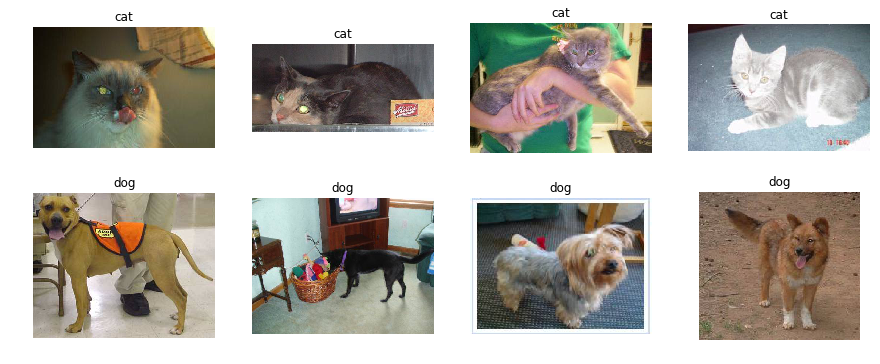

In [3]:
train_data_dir = '../../datasets/CatsDogs/train'
valid_data_dir = '../../datasets/CatsDogs/validation'
nb_train_samples = 2000
nb_valid_samples = 800

fig = plot.figure(figsize=(15,6))
for i, j in enumerate(nr.randint(0, 1000, 4)):
    fig.add_subplot(2,4, i+1)
    img = plot.imread('{}/cats/cat.{}.jpg'.format(train_data_dir, j))
    plot.imshow(img)
    plot.title('cat')
    plot.axis('off')
    
    fig.add_subplot(2,4, i+5)
    img = plot.imread('{}/dogs/dog.{}.jpg'.format(train_data_dir, j))
    plot.imshow(img)
    plot.title('dog')
    plot.axis('off')


In [4]:
batch_size = 40
img_width, img_height = 150, 150

datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
        train_data_dir,                       # as amostras de treinamento
        target_size=(img_width, img_height),
        batch_size=batch_size,                # batch size do SGD
        shuffle=False,
)

valid_generator = datagen.flow_from_directory(
        valid_data_dir,                       # as amostras de validação
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False,
)


Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


## VGG Features

[![VGG Network Layers](https://blog.keras.io/img/imgclf/vgg16_original.png)]()

In [5]:
from keras.applications.vgg16 import VGG16
VGG16(include_top=False, weights='imagenet', input_shape=(150,150, 3)).summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [6]:
def get_and_save_vgg_features(trn_feat_fn, val_feat_fn):
    from keras.applications.vgg16 import VGG16
    # carrega apenas a parte convolucional (include_top=False) da VGG16
    vgg = VGG16(include_top=False, weights='imagenet', input_shape=(img_height, img_width, 3))
    
    train_features = vgg.predict_generator(train_generator, nb_train_samples/batch_size)
    np.save(open(trn_feat_fn, 'wb'), train_features)
    
    valid_features = vgg.predict_generator(valid_generator, nb_valid_samples/batch_size)
    np.save(open(val_feat_fn, 'wb'), valid_features)
    
    return train_features, valid_features

trn_feat_fn = '../../models/vgg16_150x150_features_train.npy'
val_feat_fn = '../../models/vgg16_150x150_features_valid.npy'

if not os.path.isfile(trn_feat_fn):
    train_features, valid_features = get_and_save_vgg_features(trn_feat_fn, val_feat_fn)
else:
    train_features = np.load(open(trn_feat_fn, 'rb'))
    valid_features = np.load(open(val_feat_fn, 'rb'))
    
train_labels = np.array([0] * 1000 + [1] * 1000)
valid_labels = np.array([0] * 400 + [1] * 400)

## Modelo
A rede neural utilizada é especificada a seguir.

In [7]:
class MyNet:
    @staticmethod
    def build(img_width, img_height):
        model = Sequential()
        model.add(Flatten(input_shape=train_features.shape[1:]))
        model.add(Dense(256, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(1, activation='sigmoid'))
        return model

MyNet.build(img_width, img_height).summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 2,097,665
Trainable params: 2,097,665
Non-trainable params: 0
_________________________________________________________________


In [8]:
model_name = '../../models/cats_dogs_vgg'

if not os.path.isfile(model_name + '.model'):
    print("[INFO] creating model...")
    model = MyNet.build(img_width, img_height)
    
    # History, checkpoint, earlystop, plot losses:
    histo = TrainingPlotter(n=1, filepath=model_name, patience=15)
    
    # initialize the optimizer and model
    print("[INFO] compiling model...")
    opt = SGD(lr=0.01, momentum=0.9, nesterov=True)
    model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])    
    
else:
    print("[INFO] loading model...")
    model, histo = load_model_and_history(model_name)


[INFO] creating model...
[INFO] compiling model...


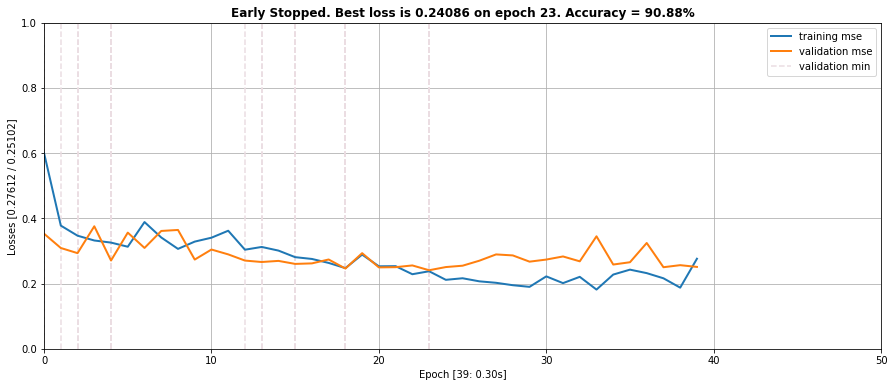

In [9]:
nb_epoch = 50
ploss = 1.0

nepochs = nb_epoch - histo.get_nepochs()

fig = plot.figure(figsize=(15,6))
plot.ylim(0.0, ploss)
plot.xlim(0, nb_epoch)
plot.grid(True)

if nepochs > 0:
    print("[INFO] training...")
    try:
        model.fit(train_features, train_labels,
                  epochs=nepochs, batch_size=40, verbose=0,
                  callbacks=[histo],
                  validation_data=(valid_features, valid_labels))
    except KeyboardInterrupt:
        pass
else:
    print("[INFO] plotting...")
    # plot history


In [ ]:
print("[INFO] loading model...")
model, histo = load_model_and_history(model_name)
print('       from epoch {}'.format(histo.best_epoch))
print("[INFO] evaluating...")
loss, accuracy = model.evaluate(valid_features, valid_labels, batch_size=128, verbose=0)
print("[INFO] accuracy: {:.2f}%".format(accuracy * 100))


## Atividade

1. Criar a rede VGG16 com pesos vencedores da Imagenet concatena com a rede Densa treinada neste notebook. Fazer a avalição desta rede com os dados de validação.


## Aprendizados com este notebook

1. O uso de uma rede pré-treinada com pesos utilizados em competições, serve para a extração eficiente de atributos das imagens de um modo geral. 
2. Os features gerados pela rede VGG16 podem ser utilizados para classificação utilizando qualquer classificador. Neste caso utilizamos um classificador por rede neural densa. Desta forma, poderemos posteriormente treinar a rede toda. Isso será visto no próximo notebook.
